In [1]:
%load_ext autoreload

In [5]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score
import sys
import torch

sys.path.append('../..')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

In [4]:
print(os.system('hostname'))

node084
0


# Functions

In [6]:
def rnn(t, x, W, tau, g):
    return (1/tau)*(-x + g*W @ np.tanh(x))

def rnn_jacobian(x, W, g, tau, dt, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
    x = numpy_torch_conversion(x, use_torch, device, dtype)
    W = numpy_torch_conversion(W, use_torch, device, dtype)
    if use_torch:
        I = torch.eye(x.shape[1]).type(dtype).to(device)
        if len(x.shape) == 1:
            return I + (dt/tau)*(-I + (g*W @ torch.diag(1 - torch.tanh(x)**2)))
        else:
            return I.unsqueeze(0) + (dt/tau)*(-I.unsqueeze(0) + (g*W*((1 - torch.tanh(x)**2).unsqueeze(1))))
    else:
        if len(x.shape) == 1:
            return np.eye(N) + (dt/tau)*(-np.eye(N) + (g*W @ np.diag(1 - np.tanh(x)**2)))
        else:
            print((1 - np.tanh(x)**2)[:, np.newaxis].shape)
            return np.eye(N)[np.newaxis] + (dt/tau)*(-np.eye(N)[np.newaxis] + (g*W*(1 - np.tanh(x)**2)[:, np.newaxis]))

def compute_lyaps(Js, dt=1, k=None, worker_num=None, message_queue=None, verbose=False):
    T, n = Js.shape[0], Js.shape[1]
    old_Q = np.eye(n)
    if k is None:
        k = n
    old_Q = old_Q[:, :k]
    lexp = np.zeros(k)
    lexp_counts = np.zeros(k)
    for t in tqdm(range(T), disable=not verbose):
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

        if message_queue is not None:
            message_queue.put((worker_num, "task complete", "DEBUG"))
    
    return np.divide(lexp, lexp_counts)*(1/dt)

def compute_lyaps_and_jacobians(x, W, g, tau, dt, k=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor', worker_num=None, message_queue=None, verbose=False):
    T, n = x.shape[0], x.shape[1]
    old_Q = np.eye(n)
    if k is None:
        k = n
    old_Q = old_Q[:, :k]
    lexp = np.zeros(k)
    lexp_counts = np.zeros(k)
    for t in tqdm(range(T), disable=not verbose):
        J = rnn_jacobian(x[t], W, g, tau, dt, use_torch, device, dtype)
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(J, old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

        if message_queue is not None:
            message_queue.put((worker_num, "task complete", "DEBUG"))
    
    return np.divide(lexp, lexp_counts)*(1/dt)

# Data Storage

In [7]:
chaotic_net_folder = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets_multirun_stochastic_1024'

In [8]:
os.makedirs(chaotic_net_folder, exist_ok=True)

# Initial

In [9]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [10]:
# N = list(full_signals.values())[0].shape[2]
N = 1024
T = list(full_signals.values())[0].shape[1]
dt = 0.01
tau = 0.1

batch_size = 500
num_batches = int(T/batch_size)

device = 'cuda'
use_torch = True

In [11]:
# signals = {key: signal[0] for key, signal in full_signals.items()}
# ret = dict(
#     W=W,
#     lyaps=lyaps,
#     signals=signals,
#     dt=dt,
#     tau=tau,
#     N=N,
#     T=T
# )
# pd.to_pickle(ret, os.path.join(chaotic_net_folder, "RUN_ORIG"))

# Run

In [12]:
N = 1024
T = 20000
dt = 0.001
tau = 0.01

In [13]:
g_vals = [0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 1, 1.025, 1.05, 1.075, 1.1, 1.125, 1.15, 1.175, 1.2, 1.25, 1.3, 1.35, 1.4, 1.5, 1.6, 1.7, 1.8]

In [14]:
NUM_RUNS = 10

In [15]:
t_span = [0, 200]
t_eval = np.arange(t_span[0], t_span[1], dt)

In [16]:
def g_dW(x):
    return 0.05

for run_num in tqdm(range(NUM_RUNS)):
    if not os.path.exists(os.path.join(chaotic_net_folder, f"RUN_{run_num}")):
        print("="*40)
        print(f"RUN_NUM = {run_num}")
        print("="*40)

        signals = {}
        lyaps = {}

        np.random.seed(42 + run_num)

        print("Simulating signals...")
        W = np.random.randn(N, N)/np.sqrt(N)
        for g in tqdm(g_vals):
            dW = np.sqrt(dt) * np.random.randn(T,N)
            x0 = np.random.randn(N)
             # Define the function g(x)
            

            # Initialize the x array
            x = np.zeros((T, N))
            x[0] = np.random.randn(N)

            # Simulate the stochastic differential equation
            for i in range(1, T):
                x[i] = x[i-1] + rnn((i - 1)*dt, x[i-1], W, tau, g) * dt + g_dW(x[i-1]) * dW[i]
                
            signals[g] = x
        print("Signals simulated!")

        print("MAIN ANALYSIS:")
        for key in tqdm(g_vals):
            print("-"*20)
            print(f"g = {key}")
            print("-"*20)
            signal = signals[g]
            g = key

            # Js = np.zeros((signal.shape[0], N, N))
            # print("Computing Jacobians..")
            # for batch_num in tqdm(range(num_batches)):
            #     start_ind = batch_num*batch_size
            #     end_ind = np.min([(batch_num + 1)*batch_size, signal.shape[0]])
            #     batch_Js = rnn_jacobian(signal[start_ind:end_ind], W, g, tau, dt, N, use_torch=use_torch, device=device)
            #     if device == 'cuda':
            #         batch_Js = batch_Js.cpu()
            #     Js[start_ind:end_ind] = batch_Js

            # print("Computing Lyaps...")
            # lyaps[key] = compute_lyaps(Js, dt=dt, k=3, verbose=True)
            
            lyaps[key] = compute_lyaps_and_jacobians(signal, W, g, tau, dt, k=3, use_torch=False, device='cpu', verbose=True)

        ret = dict(
            W=W,
            lyaps=lyaps,
            signals=signals,
            dt=dt,
            tau=tau,
            N=N,
            T=T
        )
        pd.to_pickle(ret, os.path.join(chaotic_net_folder, f"RUN_{run_num}"))

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
plt.plot(ret['signals'][0.75][:, 0])
plt.plot(ret['signals'][1.1][:, 0])

NameError: name 'ret' is not defined

# Test an Example

In [17]:
run_ret = ret

NameError: name 'ret' is not defined

In [1015]:
num_indices = 50
test_keys = g_vals

In [1017]:
parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([2, 5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]),
    r_vals = np.array([2, 3, 5, 10, 30, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400])
)

parameter_grid_orig = parameter_grid
parameter_grid.matrix_size_vals = parameter_grid_orig.matrix_size_vals[parameter_grid_orig.matrix_size_vals >= num_indices]
parameter_grid.matrix_size_vals = parameter_grid.matrix_size_vals[parameter_grid.matrix_size_vals <= 50*num_indices]
        
noise_sd = 0

In [1018]:
indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)

full_signals = run_ret['signals']
signals = {key: full_signal[:, indices] for key, full_signal in full_signals.items()}
        
for key in signals.keys():
    signals[key] += np.random.randn(T, len(indices))*noise_sd

results = []
iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
for window in parameter_grid.window_vals:
    for matrix_size in parameter_grid.matrix_size_vals:
        delases = {}
        exp_variances = {}
#         train_signals = []
        test_signals = {}
        for key, signal in signals.items():
            if key in test_keys:
                train_signal = signal[transient:transient + window]
                test_signal = signal[transient + window:transient + window + prediction_time]
                delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=use_torch, device=device, dtype='torch.DoubleTensor')
                delase.to('cpu')
                if use_torch:
                    exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                else:
                    exp_variances[key] = delase.cumulative_explained_variance
                delases[key] = delase
    #             train_signals.append(train_signal)
                test_signals[key] = test_signal
        for r in parameter_grid.r_vals:
            if r <= np.min([delase.n*delase.p for delase in delases.values()]):
                stab_curves = {}
                AICs = {}
                for key, delase in delases.items():
                    delase.to(device)
                    delase.compute_havok_dmd(r=r)
                    delase.get_stability(max_freq=500, max_unstable_freq=125)

                    AICs[key] = compute_AIC(delase, test_signals[key], norm=True)
                    if use_torch:
                        stab_curves[key] = delase.stability_params.cpu()
                    else:
                        stab_curves[key] = delase.stability_params

                if use_torch:
                    exp_variances = np.array([delase.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
                else:
                    exp_variances = np.array([delase.cumulative_explained_variance[r-1] for delase in delases.values()])

                results.append(dict(
                    window=window,
                    matrix_size=matrix_size,
                    r=r,
                    exp_variances=exp_variances,
                    AICs=AICs,
                    stab_curves=stab_curves,
                ))
            iterator.update()
iterator.close()
results = pd.DataFrame(results)
results_dict = {}
# for key in signals.keys():
for key in test_keys:
    ret_temp = results.copy()
    ret_temp = ret_temp.drop('AICs', axis=1)
    ret_temp = ret_temp.drop('stab_curves', axis=1)
    ret_temp = ret_temp.drop('exp_variances', axis=1)
    ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
    ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
    ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
    results_dict[key] = ret_temp

  0%|          | 0/168 [00:00<?, ?it/s]

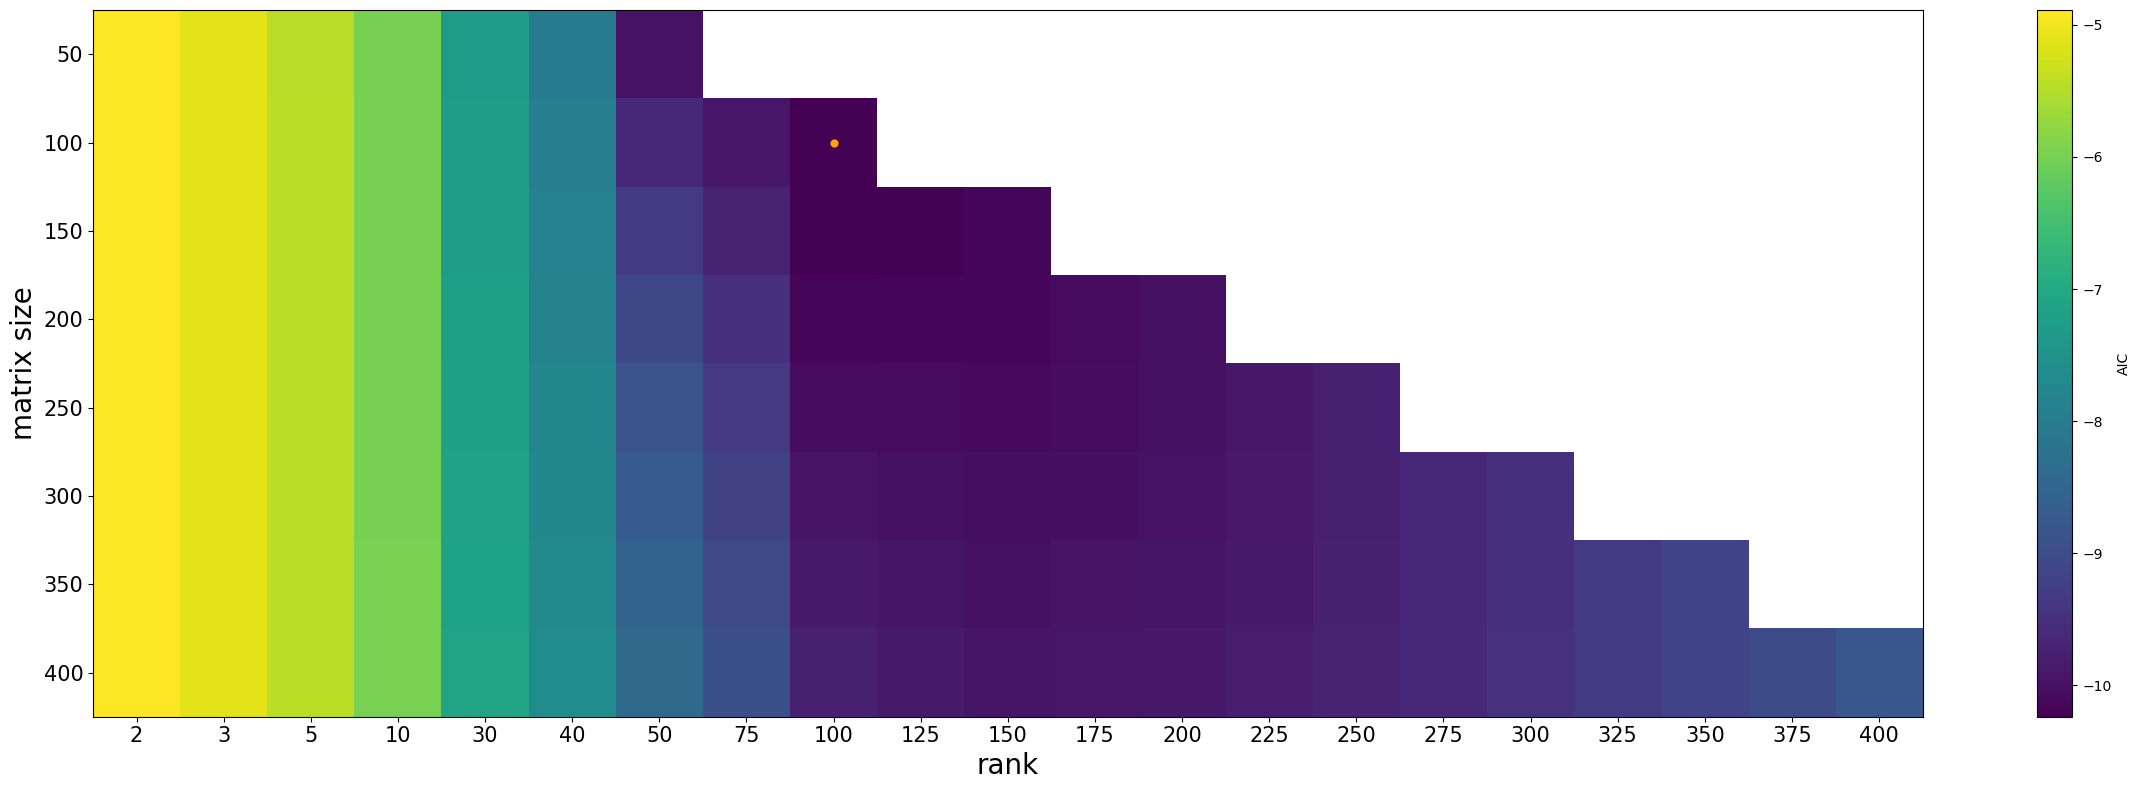

In [1019]:
plot_AIC(results_dict)

# Compute Dynamical Models

In [18]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([10000]),
#     matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000]),
#     r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400, 1600, 1800])
# )

prediction_time = 4000
transient = 2000
window = 10000

mean_stab_curve = True
# keys = np.array(list(signals.keys()))
# key_inds = [i for i in range(len(keys)) if keys[i] >= 1.1]

num_indices_list = [2, 10, 20, 30, 40, 50]

parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([2, 5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]),
    r_vals = np.array([2, 3, 5, 10, 30, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400])
)
device='cuda'

noise_sd = 0

In [19]:
files = [f for f in os.listdir(chaotic_net_folder) if 'VAR' not in f and 'DeLASE' not in f and 'dynamics' not in f]
files.sort(key=lambda x: int(x.split('_')[1]) if x.split('_')[1] != 'ORIG' else -1)

In [20]:
for f in files:
    if not os.path.exists(os.path.join(chaotic_net_folder, f"{f}_dynamics")):
        print("="*40)
        print(f"{f}")
        print("="*40)

        if f == "RUN_ORIG":
            np.random.seed(41)
        else:
            np.random.seed(42 + int(f.split('_')[1]))

        run_ret = pd.read_pickle(os.path.join(chaotic_net_folder, f))
        
        all_index_rets = {}
        parameter_grid_orig = deepcopy(parameter_grid)
        for num_indices in num_indices_list:
            print(f"num_indices = {num_indices}")
            parameter_grid.matrix_size_vals = parameter_grid_orig.matrix_size_vals[parameter_grid_orig.matrix_size_vals >= num_indices]
            if num_indices < 10:
                parameter_grid.matrix_size_vals = parameter_grid.matrix_size_vals[parameter_grid.matrix_size_vals <= 50*num_indices]
            indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)

            full_signals = run_ret['signals']
            signals = {key: full_signal[:, indices] for key, full_signal in full_signals.items()}
            keys = list(signals.keys())
            for key in signals.keys():
                signals[key] += np.random.randn(T, len(indices))*noise_sd

            # VAR
            A_mats = {}
            criticality_inds = {}
            AIC_VAR_normed = {}
            pb_AIC = {}
            for key, signal in tqdm(signals.items(), total=len(signals)):
                train_signal = signal[transient:transient + window]
                test_signal = signal[transient + window:transient + window + prediction_time]

                A_VAR = np.linalg.lstsq(train_signal[:-1], train_signal[1:], rcond=1e-20)[0].T
                A_mats[key] = A_VAR
                criticality_inds[key] = np.sort(np.abs(np.linalg.eigvals(A_VAR)))[::-1]
                n_pts = test_signal.shape[0] - 1
                preds = (A_VAR@test_signal[:-1].T).T
                AIC_VAR_normed[key] = float(n_pts*np.log(((preds - test_signal[1:])**2).sum()/n_pts) + 2*(A_VAR.shape[0]*A_VAR.shape[1] + 1))/n_pts
                pb_AIC[key] = float(n_pts*np.log(((test_signal[:-1] - test_signal[1:])**2).sum()/n_pts))/n_pts
            print("Computing DeLASE...")
            results = []
            iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
            for window in parameter_grid.window_vals:
                for matrix_size in parameter_grid.matrix_size_vals:
                    delases = {}
                    exp_variances = {}
            #         train_signals = []
                    test_signals = {}
                    for key, signal in signals.items():
                        train_signal = signal[transient:transient + window]
                        test_signal = signal[transient + window:transient + window + prediction_time]
                        delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, device=device)
                        delase.DMD.compute_hankel()
                        delase.DMD.compute_svd()
                        delase.to('cpu')
                        # exp_variances[key] = delase.DMD.cumulative_explained_variance.cpu().double()
                        delases[key] = delase
            #             train_signals.append(train_signal)
                        test_signals[key] = test_signal
                    for r in parameter_grid.r_vals:
                        if r <= np.min([delase.n*delase.n_delays for delase in delases.values()]):
                            stab_curves = {}
                            AICs = {}
                            for key, delase in delases.items():
                                delase.to(device)
                                delase.DMD.compute_havok_dmd(rank=r)
                                delase.get_stability(max_freq=500, max_unstable_freq=125)

                                AICs[key] = compute_AIC(delase, test_signals[key], norm=True)
                                if use_torch:
                                    stab_curves[key] = delase.stability_params.cpu()
                                else:
                                    stab_curves[key] = delase.stability_params

                            exp_variances = np.array([delase.DMD.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
            
                            results.append(dict(
                                window=window,
                                matrix_size=matrix_size,
                                r=r,
                                exp_variances=exp_variances,
                                AICs=AICs,
                                stab_curves=stab_curves,
                            ))

                        iterator.update()
            iterator.close()

            results = pd.DataFrame(results)
            results_dict = {}
            for key in signals.keys():
                ret_temp = results.copy()
                ret_temp = ret_temp.drop('AICs', axis=1)
                ret_temp = ret_temp.drop('stab_curves', axis=1)
                ret_temp = ret_temp.drop('exp_variances', axis=1)
                ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
                ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
                ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
                results_dict[key] = ret_temp


            all_index_rets[num_indices] = dict(
                delase=results_dict,
                VAR=dict(
                    A_mats=A_mats,
                    criticality_inds=criticality_inds,
                    AIC_VAR_normed=AIC_VAR_normed
                ),
                pb=dict(
                    AIC=pb_AIC
                )
            )
            
        pd.to_pickle(all_index_rets, os.path.join(chaotic_net_folder, f"{f}_dynamics"))

In [75]:
run0_orig = pd.read_pickle(os.path.join(chaotic_net_folder, "RUN_0_dynamics"))

# Test an Example Again

In [768]:
g_vals = list(signals.keys())

In [789]:
g_min = 0.75
g_max = 1.4

In [790]:
clipped_g_vals = [g for g in g_vals if g >= g_min and g <= g_max]

In [791]:
window, matrix_size, r, all_results = combine_grid_results({key: ret_dict['delase'][key] for key in clipped_g_vals})

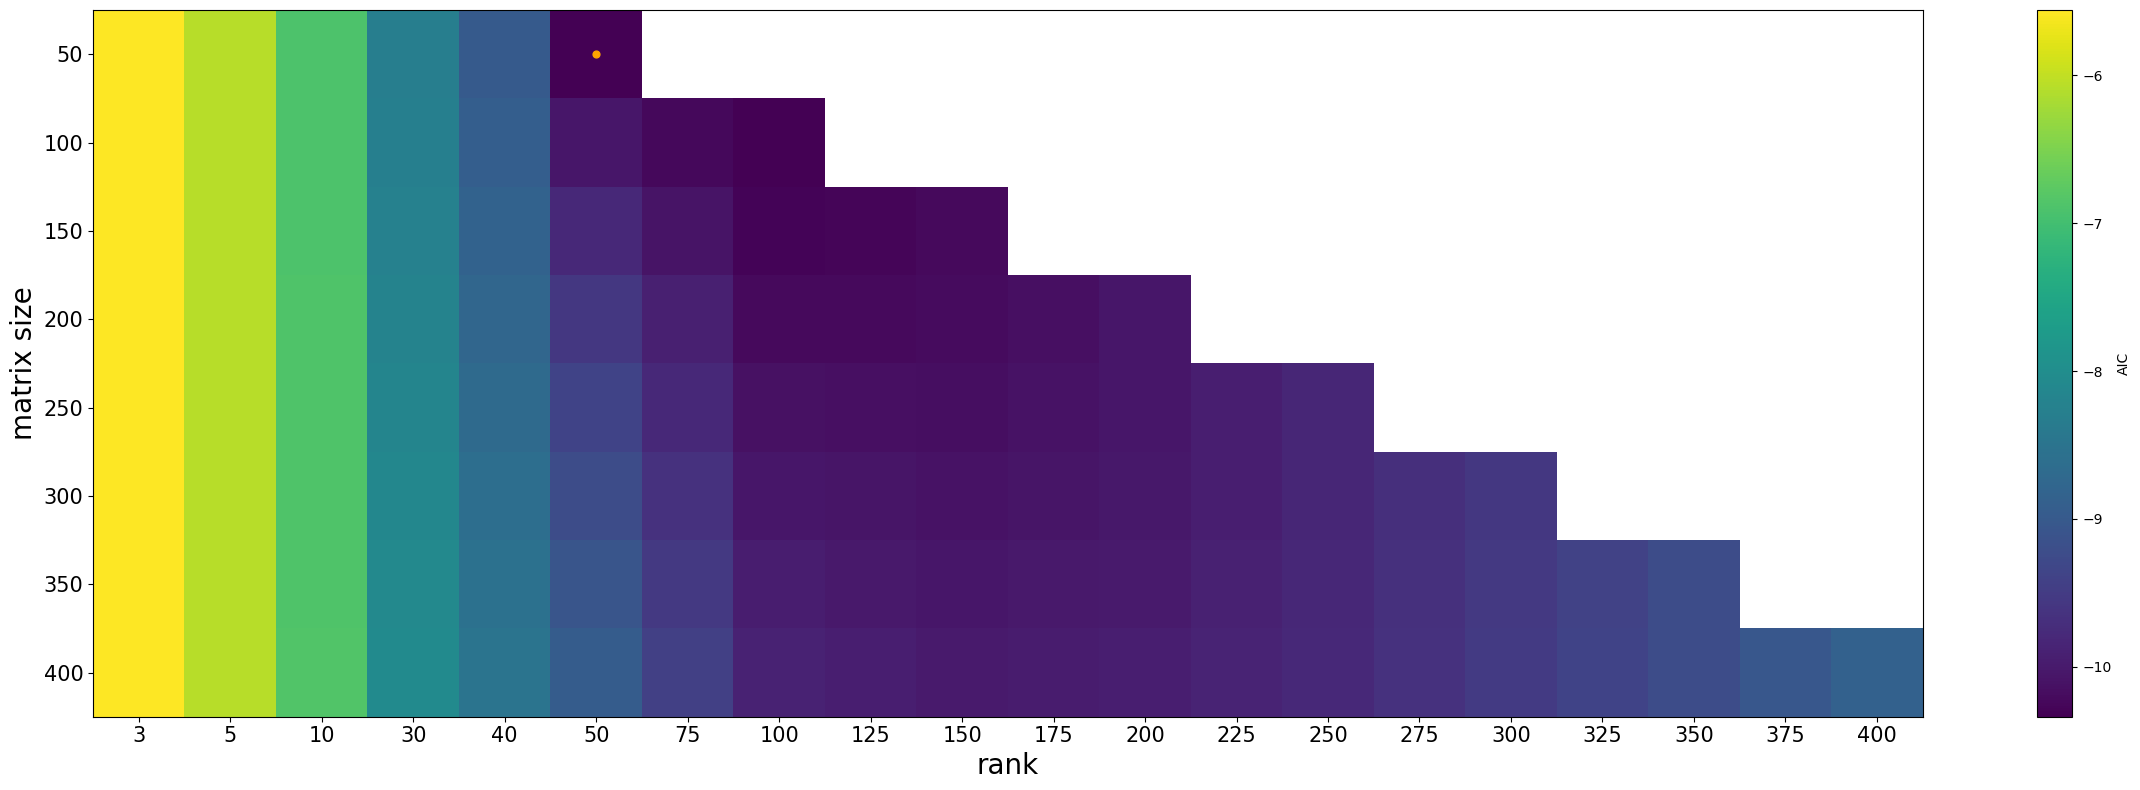

In [792]:
plot_AIC({key: ret_dict['delase'][key] for key in clipped_g_vals})

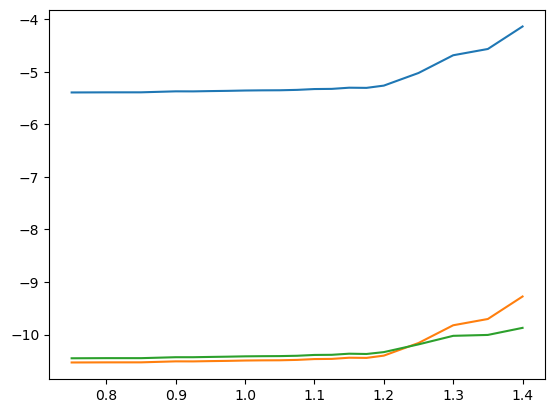

In [793]:
plt.plot(clipped_g_vals, [ret_dict['VAR']['AIC_VAR_normed'][key] for key in clipped_g_vals])
plt.plot(clipped_g_vals, [ret_dict['delase'][key].loc[(window, matrix_size, r)].AIC for key in clipped_g_vals])
plt.plot(clipped_g_vals, [ret_dict['delase'][key].loc[(window, 100, 100)].AIC for key in clipped_g_vals])

In [794]:
top_percent = 0.1
top_percent_VAR = 0.1

In [830]:
len(clipped_g_vals), len(g_vals)

(20, 20)

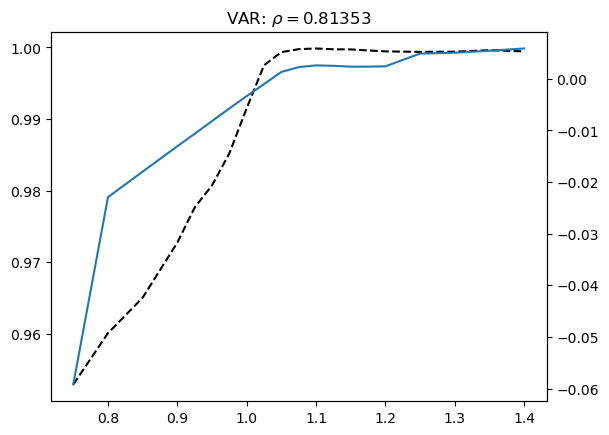

In [848]:
VAR_stab = [ret_dict['VAR']['criticality_inds'][key][:int(top_percent_VAR*len(ret_dict['VAR']['criticality_inds'][key]))].mean() for key in clipped_g_vals]
plt.plot(clipped_g_vals, VAR_stab, c='k', linestyle='--')
ax2 = plt.gca().twinx()
ax2.plot(clipped_g_vals, [run_ret['lyaps'][key][0] for key in clipped_g_vals])
plt.title(fr"VAR: $\rho = ${scipy.stats.spearmanr(VAR_stab, [run_ret['lyaps'][key][0] for key in clipped_g_vals])[0]:.5f}")
plt.show()

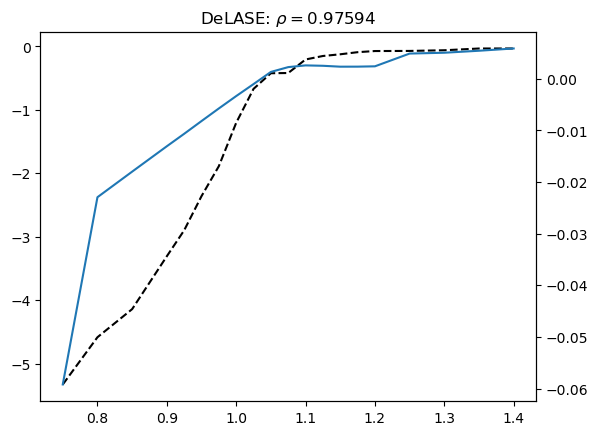

In [850]:
delase_stab = [ret_dict['delase'][key].loc[(window, matrix_size, r)].stab_curves[:int(top_percent*len(ret_dict['delase'][key].loc[(window, matrix_size, r)].stab_curves))].mean() for key in clipped_g_vals]
plt.plot(clipped_g_vals, delase_stab, c='k', linestyle='--')
ax2 = plt.gca().twinx()
ax2.plot(clipped_g_vals, [run_ret['lyaps'][key][0] for key in clipped_g_vals])
plt.title(fr"DeLASE: $\rho = ${scipy.stats.spearmanr(delase_stab, [run_ret['lyaps'][key][0] for key in clipped_g_vals])[0]:.5f}")
plt.show()

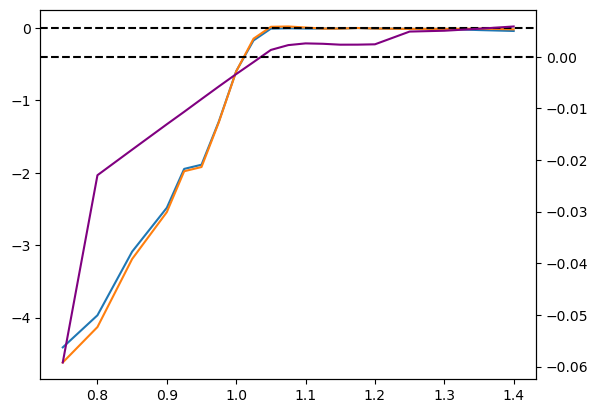

In [851]:
VAR_max = [(ret_dict['VAR']['criticality_inds'][key][0] - 1)/dt for key in clipped_g_vals]
delase_max = [ret_dict['delase'][key].loc[(window, matrix_size, r)].stab_curves[0] for key in clipped_g_vals]

plt.plot(clipped_g_vals, VAR_max)
plt.plot(clipped_g_vals, delase_max)
plt.axhline(0, linestyle='--', c='k')
ax2 = plt.gca().twinx()
ax2.plot(clipped_g_vals, [run_ret['lyaps'][key][0] for key in clipped_g_vals], c='purple')
ax2.axhline(0, linestyle='--', c='k')
plt.show()

# Analyze Results

In [21]:
def compute_nonnormality(A, normalized=False, return_eigvals=False):
    fro_norm = np.linalg.norm(A)**2
    eigvals = np.linalg.eigvals(A)
    eigval_sum = (np.abs(eigvals)**2).sum()
    if normalized:
        scale = 1/np.sqrt(A.shape[0])
    else:
        scale = 1
    nonnormality = np.sqrt(fro_norm - eigval_sum)*scale
    if return_eigvals:
        return nonnormality, eigvals
    else:
        return nonnormality

In [22]:
ret_files = [f for f in os.listdir(chaotic_net_folder) if 'DeLASE' not in f and 'VAR' not in f and 'dynamics' not in f]
ret_files.sort()

In [23]:
g_min = 0.8
g_max = 1.4

In [24]:
window = 10000
transient = 2000

In [26]:
# g_vals = np.array(list(all_rets[0]['lyaps'].keys()))

In [27]:
# pd.read_pickle(os.path.join(chaotic_net_folder, ret_file + '_dynamics')).keys()
# dict_keys([2, 10, 20, 30, 40, 50])

In [28]:
all_rets = {}
all_rets_VAR = {}
iterator = tqdm(total=len(num_indices_list)*len(ret_files))
for num_indices in num_indices_list:
    all_rets[num_indices] = []
    all_rets_VAR[num_indices] = []
    for ret_file in ret_files:
        if os.path.exists(os.path.join(chaotic_net_folder, ret_file + '_dynamics')):
            signal_rets = pd.read_pickle(os.path.join(chaotic_net_folder, ret_file))
            all_rets[num_indices].append({'lyaps': {key: signal_rets['lyaps'][key][0] for key in signal_rets['lyaps'].keys() if key >= g_min and key <= g_max}})
            all_rets_VAR[num_indices].append({'lyaps': {key: signal_rets['lyaps'][key][0] for key in signal_rets['lyaps'].keys() if key >= g_min and key <= g_max}})
            dynamic_rets = pd.read_pickle(os.path.join(chaotic_net_folder, ret_file + '_dynamics'))[num_indices]
            window, matrix_size, r, all_results = combine_grid_results({key: dynamic_rets['delase'][key] for key in dynamic_rets['delase'].keys() if key >= g_min and key <= g_max})
            print(matrix_size)
    #         matrix_size = 100
    #         r = 100 
            all_rets[num_indices][-1]['stab_curves'] = {key: dynamic_rets['delase'][key].loc[(window, matrix_size, r)].stab_curves for key in dynamic_rets['delase'].keys() if key >= g_min and key <= g_max}
            all_rets_VAR[num_indices][-1]['stab_curves'] = {key: dynamic_rets['VAR']['criticality_inds'][key] for key in dynamic_rets['VAR']['criticality_inds'].keys() if key >= g_min and key <= g_max}
    
        iterator.update()
iterator.close()

  0%|          | 0/60 [00:00<?, ?it/s]

10
10
2
50
50
50
50
50
50
50
30
30
10
50
50
50
50
50
50
50
30
30
30
50
50
50
50
50
50
50
100
100
30
100
100
50
100
50
100
100
100
100
40
100
100
50
100
50
100
100
100
100
50
100
150
50
100
50
100
150


In [35]:
g_vals = np.array(list(all_rets[10][0]['lyaps'].keys()))

In [48]:
num_indices_list

[2, 10, 20, 30, 40, 50]

In [89]:
num_indices = 10

top_percent = 0.1
top_percent_VAR = 0.1
if num_indices < 10:
    top_percent_VAR = 1/num_indices

########

k = len(all_rets[num_indices][0]['lyaps'].keys())
mean_lyaps = np.zeros(k)
mean_stab = np.zeros(k)
mean_stab_VAR = np.zeros(k)
# mean_nonnorm = np.zeros(k)

counts_lyaps = np.zeros(k)
counts_stab = np.zeros(k)
counts_stab_VAR = np.zeros(k)
# counts_nonnorm = np.zeros(k)

for ret in all_rets[num_indices]:
    mean_lyaps += np.array([ret['lyaps'][key] for key in g_vals])
    counts_lyaps += 1
    
    mean_stab += np.array([ret['stab_curves'][key][:int(top_percent*len(ret['stab_curves'][key]))].sum() for key in g_vals])
    counts_stab += np.array([int(top_percent*len(ret['stab_curves'][key])) for key in g_vals])

for ret in all_rets_VAR[num_indices]:
    mean_stab_VAR += np.array([(np.log(ret['stab_curves'][key][:int(top_percent_VAR*len(ret['stab_curves'][key]))])/dt).sum() for key in g_vals])
    counts_stab_VAR += np.array([int(top_percent_VAR*len(ret['stab_curves'][key])) for key in g_vals])
    
#     mean_nonnorm += np.array([ret['nonnormalities'][key] for key in g_vals])
#     counts_nonnorm += 1
    
mean_lyaps /= counts_lyaps
mean_stab /= counts_stab
mean_stab_VAR /= counts_stab_VAR
# mean_nonnorm /= counts_nonnorm

k = len(all_rets[num_indices][0]['lyaps'].keys())
se_lyaps = np.zeros(k)
se_stab = np.zeros(k)
se_stab_VAR = np.zeros(k)
# se_nonnorm = np.zeros(k)

for ret in all_rets[num_indices]:
    se_lyaps += (np.array([ret['lyaps'][key] for key in g_vals]) - mean_lyaps)**2
    
    se_stab +=  np.array([((ret['stab_curves'][key][:int(top_percent*len(ret['stab_curves'][key]))] - mean_stab[np.where(g_vals == key)[0]])**2).sum() for key in g_vals])
    
for ret in all_rets_VAR[num_indices]:
    se_stab_VAR +=  np.array([((np.log(ret['stab_curves'][key][:int(top_percent_VAR*len(ret['stab_curves'][key]))])/dt - mean_stab[np.where(g_vals == key)[0]])**2).sum() for key in g_vals])
    
#     se_nonnorm += (np.array([ret['nonnormalities'][key] for key in g_vals]) - mean_nonnorm)**2

se_lyaps /= counts_lyaps
se_lyaps = np.sqrt(se_lyaps)
se_lyaps /= np.sqrt(counts_lyaps)

se_stab /= counts_stab
se_stab = np.sqrt(se_stab)
se_stab /= np.sqrt(counts_stab)

se_stab_VAR /= counts_stab_VAR
se_stab_VAR = np.sqrt(se_stab_VAR)
se_stab_VAR /= np.sqrt(counts_stab_VAR)

# se_nonnorm /= counts_nonnorm
# se_nonnorm = np.sqrt(se_nonnorm)
# se_nonnorm /= np.sqrt(counts_nonnorm)

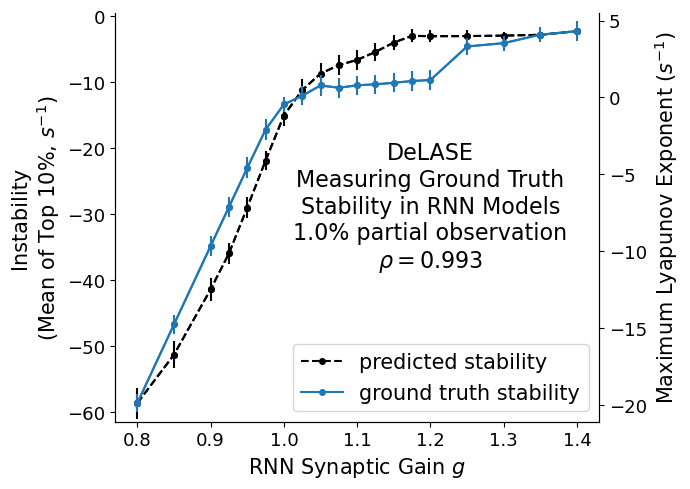

In [108]:
tick_fontsize = 13
ylabel_fontsize = 15
xlabel_fontsize = 15
title_fontsize = 16

start_pos = 0
end_pos = len(g_vals)

fig, axs = plt.subplots(1, 1, figsize=(7, 5))

ax = axs
lns = []
lns += ax.plot(g_vals[start_pos:end_pos], mean_stab[start_pos:end_pos], marker='o', linestyle='--', c='k', markersize=4, label='predicted stability')
ylim = ax.get_ylim()
# ax.fill_between(g_vals, mean_stab - se_stab, mean_stab + se_stab, alpha=0.4)
ax.errorbar(g_vals[start_pos:end_pos], mean_stab[start_pos:end_pos], marker='o', yerr=se_stab[start_pos:end_pos], linestyle='--', c='k', markersize=4)
ax.set_ylim(ylim)
ax2 = ax.twinx()
lns += ax2.plot(g_vals[start_pos:end_pos], mean_lyaps[start_pos:end_pos], marker='o', markersize=4, label='ground truth stability')
ylim = ax2.get_ylim()
ax2.errorbar(g_vals[start_pos:end_pos], mean_lyaps[start_pos:end_pos], yerr=se_lyaps[start_pos:end_pos], c='C0', marker='o', markersize=4)
# ax2.fill_between(g_vals, mean_lyaps - se_lyaps, mean_lyaps + se_lyaps, color='k', alpha = 0.1)
ax2.set_ylim(ylim)

ax.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Instability\n(Mean of Top 10%, $s^{-1}$)', fontsize=ylabel_fontsize)
ax.set_xlabel('RNN Synaptic Gain $g$', fontsize=xlabel_fontsize)

ax.text(1.2, -38, f"DeLASE\nMeasuring Ground Truth\nStability in RNN Models\n{num_indices*100/N:.1f}% partial observation\n" + fr"$\rho = ${scipy.stats.spearmanr(mean_stab[start_pos:end_pos], mean_lyaps[start_pos:end_pos])[0]:.3f}", ha='center', fontsize=title_fontsize)

ax2.tick_params(labelsize=tick_fontsize)
ax2.set_ylabel('Maximum Lyapunov Exponent ($s^{-1}$)', fontsize=ylabel_fontsize)

ax.spines[['top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax2.spines[['top']].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('right')

#  bbox_to_anchor=(1.2, 1)
plt.legend(lns, [ln.get_label() for ln in lns], loc='lower right', fontsize=15)

plt.tight_layout()
plt.show()

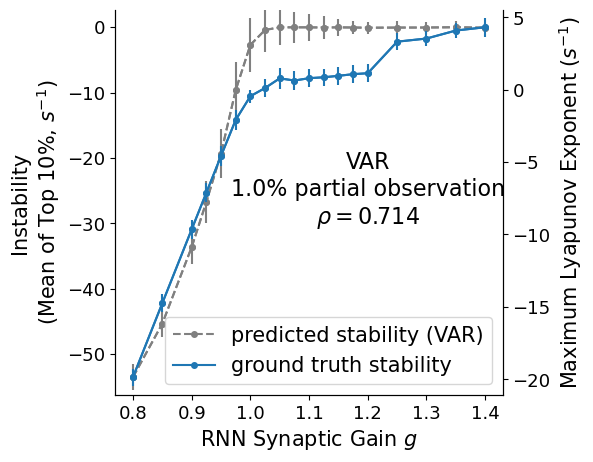

In [113]:
tick_fontsize = 13
ylabel_fontsize = 15
xlabel_fontsize = 15
title_fontsize = 16

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

ax = axs
lns = []
lns += ax.plot(g_vals[start_pos:end_pos], mean_stab_VAR[start_pos:end_pos], marker='o', linestyle='--', c='gray', markersize=4, label='predicted stability (VAR)')
ylim = ax.get_ylim()
# ax.fill_between(g_vals, mean_stab - se_stab, mean_stab + se_stab, alpha=0.4)
ax.errorbar(g_vals[start_pos:end_pos], mean_stab_VAR[start_pos:end_pos], marker='o', yerr=se_stab_VAR[start_pos:end_pos], linestyle='--', c='gray', markersize=4)
ax.set_ylim(ylim)
ax2 = ax.twinx()
lns += ax2.plot(g_vals[start_pos:end_pos], mean_lyaps[start_pos:end_pos], marker='o', markersize=4, label='ground truth stability')
ylim = ax2.get_ylim()
ax2.errorbar(g_vals[start_pos:end_pos], mean_lyaps[start_pos:end_pos], yerr=se_lyaps[start_pos:end_pos], c='C0', marker='o', markersize=4)
# ax2.fill_between(g_vals, mean_lyaps - se_lyaps, mean_lyaps + se_lyaps, color='k', alpha = 0.1)
ax2.set_ylim(ylim)

ax.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Instability\n(Mean of Top 10%, $s^{-1}$)', fontsize=ylabel_fontsize)
ax.set_xlabel('RNN Synaptic Gain $g$', fontsize=xlabel_fontsize)

ax.text(1.2, -30, f"VAR\n{num_indices*100/N:.1f}% partial observation\n" + fr"$\rho = ${scipy.stats.spearmanr(mean_stab_VAR[start_pos:end_pos], mean_lyaps[start_pos:end_pos])[0]:.3f}", ha='center', fontsize=title_fontsize)

ax2.tick_params(labelsize=tick_fontsize)
ax2.set_ylabel('Maximum Lyapunov Exponent ($s^{-1}$)', fontsize=ylabel_fontsize)

ax.spines[['top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax2.spines[['top']].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('right')

# ylim2 = [(mean_stab_VAR[start_pos:end_pos] - se_stab_VAR[start_pos:end_pos]).min(), (mean_stab_VAR[start_pos:end_pos] + se_stab_VAR[start_pos:end_pos]).max()]
# ax.set_ylim(ylim2)

#  bbox_to_anchor=(1.2, 1)
plt.legend(lns, [ln.get_label() for ln in lns], loc='lower right', fontsize=15)